# Sumarizador Automático de Texto usando Embeddings 
A proposta deste trabalho é desenvolver uma Prova de Conceito no intuito de demonstrar um sumarizador automático de texto capaz de gerar resumos extrativos de documentos usando embeddings para capturar a semântica das frases. Para os testes e avaliação, será utilizado o dataset CNN/DailyMail; ele contém artigos de notícias e seus resumos, e é amplamente utilizado para tarefas de sumarização. 

O pipeline de execução do sumarizador será composto, basicamente, pelas seguintes etapas: 
1. Pré-processamento do texto;
2. Transformar cada frase do texto em um vetor (embedding); 
3. Aplicar clusterização nesses embeddings para agrupar frases contextualmente similares; 
4. Obter as frases mais representativas de cada cluster; 
5. Compor o resumo extrativo a partir das frases obtidas.

```Observações:```

Serão utilizados e testados os seguintes modelos de embedding: ``text-embedding-3-small``, ``text-embedding-3-large`` e ``text-embedding-ada-002`` (OpenAI), ``bert-base-uncased`` (BERT), ``roberta-base`` (RoBERTa), ``paraphrase-MiniLM-L6-v2`` (S-BERT ou Sentence-BERT). Os modelos BERT e RoBERTa foram obtidos através da biblioteca "transformers" da Hugging Face, enquanto o S-BERT veio da "sentence-transformers". Não confundir o S-BERT com o modelo BERT para frases, são diferentes e possuem arquiteturas diferentes.

Para utilizar os modelos da OpenAI é necessário acesso a uma chave de API da OpenAI.

```Instruções de Uso:```

- Descomentar e executar a primeira célula para instalar as dependências necessárias. As bibliotecas que trazem ferramentas de deep learning são bem pesadas e o processo pode demorar. Lembre-se de reiniciar o kernel após isso.
- Descomentar e fazer download do 'punkt' na quarta célula. Ele é necessário para algumas funcionalidades da biblioteca nltk. Talvez também seja necessário reiniciar o kernel após isso.
- Criar um arquivo .env para guardar sua chave de API da OpenAI. O arquivo deve conter uma linha com o seguinte:  ```
        API_KEY = 'SUA-CHAVE-DE-API-OPENAI'
        ```

---

## Instalação de Dependências

In [1]:
# Uncomment to install necessary libraries and packages. Remember to restart kernel afterwards
# ! pip install numpy pandas nltk datasets python-dotenv openai matplotlib transformers torch sentence_transformers

In [126]:
from transformers import AutoTokenizer, AutoModel, BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
from nltk.cluster import KMeansClusterer
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from dotenv import load_dotenv
from openai import OpenAI
import pandas as pd
import numpy as np
import logging
import torch
import nltk
import os
import re

In [113]:
# Supress excessive warnings from transformers libraries
logging.getLogger("transformers").setLevel(logging.ERROR)
logging.getLogger("sentence_transformers").setLevel(logging.ERROR)

In [2]:
# Uncomment to download relevant tools if not already downloaded
# nltk.download('punkt')

## Conexão com a OpenAI

In [3]:
# Load enviroment variables
load_dotenv()

# Configure client with API key
client_openai = OpenAI(
    api_key=os.getenv('API_KEY'),
)

## Preparação dos Dados

In [4]:
# Load CNN/DailyMail Dataset
dataset = load_dataset('cnn_dailymail', '3.0.0')

In [5]:
# Get data that will be used for evaluation
train = dataset['train']
data = train.select(range(20))

In [6]:
# Content example from dataset
print(data[0]['article'])  # Text
print()
print(data[0]['highlights'])  # Summary

LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. Details of how

## Funções Auxiliares

In [96]:
# Function to get embedding from text using an OpenAI model
def get_embedding_openai(text, model):
   text = text.replace("\n", " ")
   return client_openai.embeddings.create(input = [text], model=model).data[0].embedding

In [103]:
# Function to get embedding from text using a model from transformers library of Huggings Face
def get_embedding_huggingface(text, model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    text = [text]

    # Tokenize sentences and get embeddings
    inputs = tokenizer(text, return_tensors='pt', padding='longest')
    with torch.no_grad():
        outputs = model(**inputs)

    # Check if the outputs contain 'last_hidden_state' or 'encoder_last_hidden_state'
    if hasattr(outputs, 'encoder_last_hidden_state'):
        embeddings = outputs.encoder_last_hidden_state.mean(dim=1)
    elif hasattr(outputs, 'last_hidden_state'):
        embeddings = outputs.last_hidden_state.mean(dim=1)
    else:
        raise ValueError("The model output does not contain expected attributes.")

    return embeddings[0].numpy()

In [109]:
# Function to get embedding from text using model Sentence-BERT
def get_embedding_sbert(text, model_name):
    model = SentenceTransformer(model_name)
    embeddings = model.encode([text])
    return embeddings[0]

In [111]:
# Works as an 'abstract' function that points to the correct embedding function
def get_embedding(text, model):
    if model in ["text-embedding-3-large", "text-embedding-3-small", "text-embedding-ada-002"]:
        embedding_function = get_embedding_openai
    elif model in ["bert-base-uncased", "roberta-base"]:
        embedding_function = get_embedding_huggingface
    elif model == "paraphrase-MiniLM-L6-v2":
        embedding_function = get_embedding_sbert
    else:
        raise ValueError("Model either doesn't exist or isn't available.")
    return embedding_function(text, model)

In [8]:
# Calculate similarity between embeddings
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

In [9]:
# Split text in sentences
def tokenize_sentences(text):
    sentences = nltk.sent_tokenize(text)
    sentences = [sentence.strip() for sentence in sentences]
    return sentences

In [10]:
# Assign clusters to embeddings and find their centroids
def kmeans_clustering(data, n_clusters, iterations=25):
    embeddings = np.array(data["embeddings"].tolist())
    kclusterer = KMeansClusterer(
            n_clusters, 
            distance=nltk.cluster.util.cosine_distance,
            repeats=iterations, 
            avoid_empty_clusters=True)
    
    assigned_clusters = kclusterer.cluster(embeddings, assign_clusters=True)
    data['cluster'] = pd.Series(assigned_clusters, index=data.index)
    data['centroid'] = data['cluster'].apply(lambda x: kclusterer.means()[x])
    return data

In [11]:
# Calculate distance of each embedding from its cluster centroid
def distance_from_centroid(data):
    def euclidean_distance(embedding, centroid):
        return np.linalg.norm(np.array(embedding) - np.array(centroid))

    # Apply to each row
    data['distance_from_centroid'] = data.apply(
        lambda row: euclidean_distance(row["embeddings"], row["centroid"]), axis=1)
    return data

## Implementação

### Pré-Processamento do Texto
Para obter resultados de melhor qualidade no dataset CNN/DailyMail, foi realizado um pré-processamento de texto nos artigos que iremos utilizar. Isso consistiu de:
- Remover frases poluentes no início e fim dos artigos, que geralmente são informações referentes ao canal de notícias de onde o texto foi retirado e sem relação direta com o artigo em si.
- Limpar o texto de espaços desnecessários e caracteres especiais soltos.
- Remover frases muito curtas, com menos de 3 palavras.

Devido ao fato da nossa solução usar modelos de embeddings baseados em LLMs e treinados em corpus massivo de dados, capazes de captar as nuances e semântica intrínseca do texto ao invés de pura sintaxe, consideramos desnecessário aplicar técnicas de pré-processamento mais drásticas como remoção de stopwords e stemming, além de que nesse processo parte do significado e contexto poderia ser perdido, o que reduziria o desempenho.

In [74]:
# Remove sentences at the beginning and end of text that are not useful
def remove_polluting_phrases(text):
    text = re.sub(r"Editor's note:", '', text, flags=re.IGNORECASE).strip()

    start_phrase = text.find("--")
    if start_phrase != -1:
        text = text[start_phrase + 3:]

    end_phrase = text.find("E-mail to a friend")
    if end_phrase != -1:
        text = text[:end_phrase]
    
    return text

In [75]:
# Remove unnecessary spaces and stray special characters
def clean_text(text):
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\s+\.', '.', text).strip()
    text = re.sub(r'\s[^\w\s]\s', ' ', text)
    return text

In [76]:
# Remove sentences with few words
def remove_short_sentences(text, min_length=3):
    sentences = tokenize_sentences(text)
    filtered_sentences = [sentence.strip() for sentence in sentences if len(sentence.split()) > min_length]
    return ' '.join(filtered_sentences)

In [77]:
def preprocess_text(text):
    text = remove_polluting_phrases(text)
    text = remove_short_sentences(text)
    text = clean_text(text)
    return text

In [78]:
# Sample data for testing
text = data[0]['article']
print("No Preprocessing:")
print(text)
print("\nWith Preprocessing:")
print(preprocess_text(text))

No Preprocessing:
LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office cha

### Sumarização

In [79]:
# Summarize text
def summarize_text(text, model, n_clusters=3, output_as_list=False):
    # Preprocess text
    text = preprocess_text(text)

    # Create a dataframe with the text sentences
    sentences = tokenize_sentences(text)
    df_sentences = pd.DataFrame({"sentences" : sentences})

    # Transform sentences into embeddings using an NLP model
    df_sentences['embeddings'] = df_sentences['sentences'].apply(lambda x: get_embedding(x, model))

    # Cluster sentence embeddings with KMeans
    df_sentences = kmeans_clustering(df_sentences, n_clusters)

    # Find distance of each embedding to its cluster's centroid
    df_sentences = distance_from_centroid(df_sentences)

    # Compose summary with each cluster's most meaninful sentence - embedding with the least distance to centroid
    summary = df_sentences.sort_values('distance_from_centroid', ascending = True) \
                            .groupby('cluster').head(1) \
                            .sort_index()['sentences'] \
                            .tolist()
    if output_as_list: 
        return summary
    else:
        # Format summary as a string
        summary_str = ' '.join(summary)
        return summary_str

In [81]:
# Sample data for testing
text = data[0]['article']
model = "text-embedding-3-large"
summary = summarize_text(text, model, 3, True)

print("Reference Summary:")
print(data[0]['highlights'])

print("\nGenerated Summary:")
for sentence in summary:
    print(sentence)

Reference Summary:
Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .
Young actor says he has no plans to fritter his cash away .
Radcliffe's earnings from first five Potter films have been held in trust fund .

Generated Summary:
Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties.
"I'll definitely have some sort of party," he said in an interview.
"People are always looking to say 'kid star goes off the rails,'" he told reporters last month.


In [142]:
# Sample data for testing
text = data[5]['article']
model = "bert-base-uncased"
summary = summarize_text(text, model, 3, True)

print("Reference Summary:")
print(data[5]['highlights'])

print("\nGenerated Summary:")
for sentence in summary:
    print(sentence)

Reference Summary:
Parents beam with pride, can't stop from smiling from outpouring of support .
Mom: "I was so happy I didn't know what to do"
Burn center in U.S. has offered to provide treatment for reconstructive surgeries .
Dad says, "Anything for Youssif"

Generated Summary:
It's the best birthday present the Iraqi family could ever have imagined for their boy: Youssif turns 6 next Friday.
The foundation says it will cover all medical costs -- from surgeries for Youssif to housing costs to any social rehabilitation that might be needed for him.
CNN Iraqi staff central to bringing this story together were also overwhelmed with the generosity coming from people outside of their border.


## Avaliação da Solução
Para tentar evitar o problema de tentar avaliar essa solução com uma métrica ROUGE, visto que os resumos de referência ('highlights') não foram criados da mesma forma que os nossos, que são resumos extrativos, tentamos uma abordagem diferente. Optamos por utilizar os próprios embeddings para avaliação: a ideia foi usar a similaridade entre os embeddings do resumo gerado e do resumo de referência como score de avaliação. Desde que o mesmo modelo de embedding seja utilizado para avaliar todos os resumos gerados, a similaridade de cosseno entre eles é uma comparação válida. Isso permite calcular quantitativamente a semelhança semântica, e não apenas de sintaxe entre resumos; quanto maior essa métrica significa que o resumo gerado está mais próximo do ideal.

Essa é uma forma de avaliação parecida com o que foi usado no ROUGE-WE, discutido no artigo "Better Summarization Evaluation with Word Embeddings for ROUGE", de Jun-Ping Ng e Viktoria Abrech. O ROUGE-WE é uma métrica baseada no ROUGE, mas que usa embeddings de palavras de forma a aliviar a perda de score que se teria devido a parafraseamento do texto. Neste trabalho, no entanto, usaremos embeddings de texto completo.

Assim, vamos avaliar a solução com base na média dos scores de similaridade usando os 20 primeiros artigos do dataset de treinamento do CNN/DailyMail. Vamos comparar os resultados utilizando seis modelos diferentes de embeddings para sumarização de texto: os três modelos de embedding disponíveis da ``OpenAI`` (text-embedding-3-small, text-embedding-3-large e text-embedding-ada-002), além do ``BERT``, ``RoBERTa`` e ``S-BERT`` (Sentence-BERT).

Para a avaliação em si, será usado apenas o ``text-embedding-3-small`` para que os embeddings da avaliação sejam gerados no mesmo espaço vetorial e suas distâncias sejam comparáveis, de forma a garantir a consistência e justiça da avaliação.

In [82]:
data_df = data.to_pandas()  # contains 20 articles
data_df.head()

,article,highlights,id
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a


In [83]:
# Get articles and validation summaries we will use for evaluation
articles = data_df["article"].tolist()
ref_summaries = data_df["highlights"].tolist()

### Geração dos Resumos
Gerando resumos dos artigos de notícias com nosso sumarizador, usando múltiplos modelos de embeddings.

In [87]:
model_tel = "text-embedding-3-large"
gen_summaries_tel = [summarize_text(text=article, model=model_tel, n_clusters=3) for article in articles]

In [88]:
model_tes = "text-embedding-3-small"
gen_summaries_tes = [summarize_text(text=article, model=model_tes, n_clusters=3) for article in articles]

In [89]:
model_ada = "text-embedding-ada-002"
gen_summaries_ada = [summarize_text(text=article, model=model_ada, n_clusters=3) for article in articles]

In [84]:
model_bert = "bert-base-uncased"
gen_summaries_bert = [summarize_text(text=article, model=model_bert, n_clusters=3) for article in articles]

In [91]:
model_roberta = "roberta-base"
gen_summaries_roberta = [summarize_text(text=article, model=model_roberta, n_clusters=3) for article in articles]

In [114]:
model_sbert = "paraphrase-MiniLM-L6-v2"
gen_summaries_sbert = [summarize_text(text=article, model=model_sbert, n_clusters=3) for article in articles]

### Comparar com os Resumos de Referência

In [ ]:
# Função para avaliar a solução usando similaridade entre embeddings
def evaluate_summaries(generated_summaries, reference_summaries, embedding_model="text-embedding-3-small"):
    similarities = []
    
    for gen_summary, ref_summary in zip(generated_summaries, reference_summaries):
        gen_embedding = get_embedding(gen_summary, embedding_model)
        ref_embedding = get_embedding(ref_summary, embedding_model)
        
        similarity = cosine_similarity(gen_embedding, ref_embedding)
        similarities.append(similarity)
    
    mean_similarity = np.mean(similarities)
    return mean_similarity

In [99]:
score_tel = evaluate_summaries(gen_summaries_tel, ref_summaries)
print(f"Using text-embedding-3-large -- Score: {score_tel}")

Using text-embedding-3-large -- Score: 0.7088255374317931


In [96]:
score_tes = evaluate_summaries(gen_summaries_tes, ref_summaries)
print(f"Using text-embedding-3-small -- Score: {score_tes}")

Using text-embedding-3-small -- Score: 0.676615599976754


In [95]:
score_ada = evaluate_summaries(gen_summaries_ada, ref_summaries)
print(f"Using text-embedding-ada-002 -- Score: {score_ada}")

Using text-embedding-ada-002 -- Score: 0.6761565650747232


In [94]:
score_bert = evaluate_summaries(gen_summaries_bert, ref_summaries)
print(f"Using bert-base-uncased -- Score: {score_bert}")

Using bert-base-uncased -- Score: 0.6524377890385338


In [95]:
score_roberta = evaluate_summaries(gen_summaries_roberta, ref_summaries)
print(f"Using roberta-base -- Score: {score_roberta}")

Using roberta-base -- Score: 0.6120490668791113


In [115]:
score_sbert = evaluate_summaries(gen_summaries_sbert, ref_summaries)
print(f"Using sentence-transformers -- Score: {score_sbert}")

Using sentence-transformers -- Score: 0.657800673477157


## Vizualização dos Resultados

In [134]:
scores = {
    "3-small": 0.676615599976754,
    "3-large": 0.7088255374317931,
    "ada-002": 0.6761565650747232,
    "BERT": 0.6524377890385338,
    "RoBERTa": 0.6120490668791113,
    "S-BERT": 0.657800673477157
}

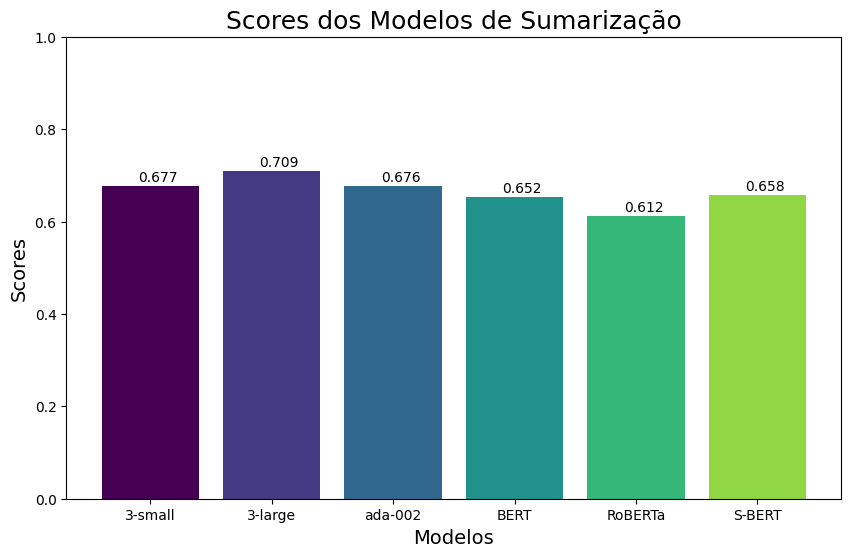

In [140]:
models = list(scores.keys())
values = list(scores.values())

# Colors
cmap = plt.colormaps['viridis']
colors = [cmap(i / len(models)) for i in range(len(models))]

# Plot bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(models, values, color=colors)

plt.xlabel('Modelos', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.title('Scores dos Modelos de Sumarização', fontsize=18)
plt.ylim(0, 1)

# Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2 - 0.1, yval + 0.01, round(yval, 3))

plt.show()